**타이타닉 우주선이 우주를 비행하다가 침몰 ... 승객이 튀어져 나가버렷는데 찾으러 가야하는 문제임.**

데이터 필드
- **PassengerID**: gggg_pp 승객 탑승아이디 출발 그룹으루 분류
- **HomePlanet**: 출발 지 행성 
- **CroySleep**: 냉동상태로 이동 여부  (????? 수면마취급인가? 뭐지???)
- **Cabin**: 승객이 객실 위치 Deck(아직 뭘 의미하는지 모름)/Num/Side(Side P or S 좌현 우현)\
- **Destination**: 목적지 승객이 내릴 장소
- **Age**
- **VIP**
- **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck**: 부가서비스 추가금액(우주선 좋은데?)
- **Name**: 이게 아무런 상관관계가 없어보이지만.. 낚시당할수도 있어 분석해야해
- **Transported**: 예측필드 승객이 튕겨나가 버렸는지 여부

In [31]:
# 우주타이타닉 문제
import pandas as pd

train_df = pd.read_csv('data/train.csv')



test_y = pd.read_csv('data/test.csv')
# test_y['VIP'] = test_y['VIP'].astype(int)
tmp_train_df = train_df.drop(columns=['Transported'])
train_means = tmp_train_df.select_dtypes(include=['number']).mean()  # 수치형 열 평균
train_modes = tmp_train_df.select_dtypes(exclude=['number']).mode().iloc[0]  # 범주형 열 최빈값
for col in train_means.index:
    test_y[col] = test_y[col].fillna(train_means[col])

for col in train_modes.index:
    test_y[col] = test_y[col].fillna(train_modes[col])
print(test_y.isna().sum())  # 대체 후 결측치 확인

print(train_df.head())
print(len(train_df))
train_df = train_df.dropna()
print(len(train_df))
train_df['Deck'] = train_df['Cabin'].str.split('/').str[0]
train_df['Side'] = train_df['Cabin'].str.split('/').str[2]

train_df['HomePlanet'] = train_df['HomePlanet'].astype('category')
train_df['HomePlanet'] = train_df['HomePlanet'].cat.codes

train_df['Destination'] = train_df['Destination'].astype('category')
train_df['Destination'] = train_df['Destination'].cat.codes

train_df['Side'] = train_df['Side'].astype('category')
train_df['Side'] = train_df['Side'].cat.codes

train_df['Deck'] = train_df['Deck'].astype('category')
train_df['Deck'] = train_df['Deck'].cat.codes

train_df['SideDeck'] = train_df['Deck'] + train_df['Side']
train_df['SideDeck'] = train_df['SideDeck'].astype('category')
train_df['SideDeck'] = train_df['SideDeck'].cat.codes

train_df['VIP'] = train_df['VIP'].astype(int)
train_df['Transported'] = train_df['Transported'].astype(int)
train_df['CryoSleep'] = train_df['CryoSleep'].astype(int)

train_df['Cabin_Num'] = pd.to_numeric(train_df['Cabin'].str.split('/').str[1], errors='coerce')
train_df['Cabin_Num_bin'] = pd.qcut(train_df['Cabin_Num'], q=5, duplicates='drop')


luxury_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

train_df['Total_Spend'] = train_df[luxury_cols].sum(axis=1)
train_df['Spend_Ratio'] = train_df['Total_Spend'] / (train_df['Age'] + 1)  # 0 나누기 방지


test_y['Total_Spend'] = test_y[luxury_cols].sum(axis=1)
test_y['Spend_Ratio'] = test_y['Total_Spend'] / (test_y['Age'] + 1)

test_y['Cabin_Num'] = pd.to_numeric(test_y['Cabin'].str.split('/').str[1], errors='coerce')
test_y['Cabin_Num_bin'] = pd.qcut(test_y['Cabin_Num'], q=5, duplicates='drop')

test_y['Deck'] = test_y['Cabin'].str.split('/').str[0]
test_y['Side'] = test_y['Cabin'].str.split('/').str[2]

test_y['HomePlanet'] = test_y['HomePlanet'].astype('category')
test_y['HomePlanet'] = test_y['HomePlanet'].cat.codes

test_y['Destination'] = test_y['Destination'].astype('category')
test_y['Destination'] = test_y['Destination'].cat.codes

test_y['Side'] = test_y['Side'].astype('category')
test_y['Side'] = test_y['Side'].cat.codes

test_y['Deck'] = test_y['Deck'].astype('category')
test_y['Deck'] = test_y['Deck'].cat.codes

test_y['SideDeck'] = test_y['Deck'] + test_y['Side']
test_y['SideDeck'] = test_y['SideDeck'].astype('category')
test_y['SideDeck'] = test_y['SideDeck'].cat.codes

test_y['VIP'] = test_y['VIP'].astype(int)
test_y['CryoSleep'] = test_y['CryoSleep'].astype(int)


PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
dtype: int64
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0

/tmp/ipykernel_121755/1051985998.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_y[col] = test_y[col].fillna(train_modes[col])


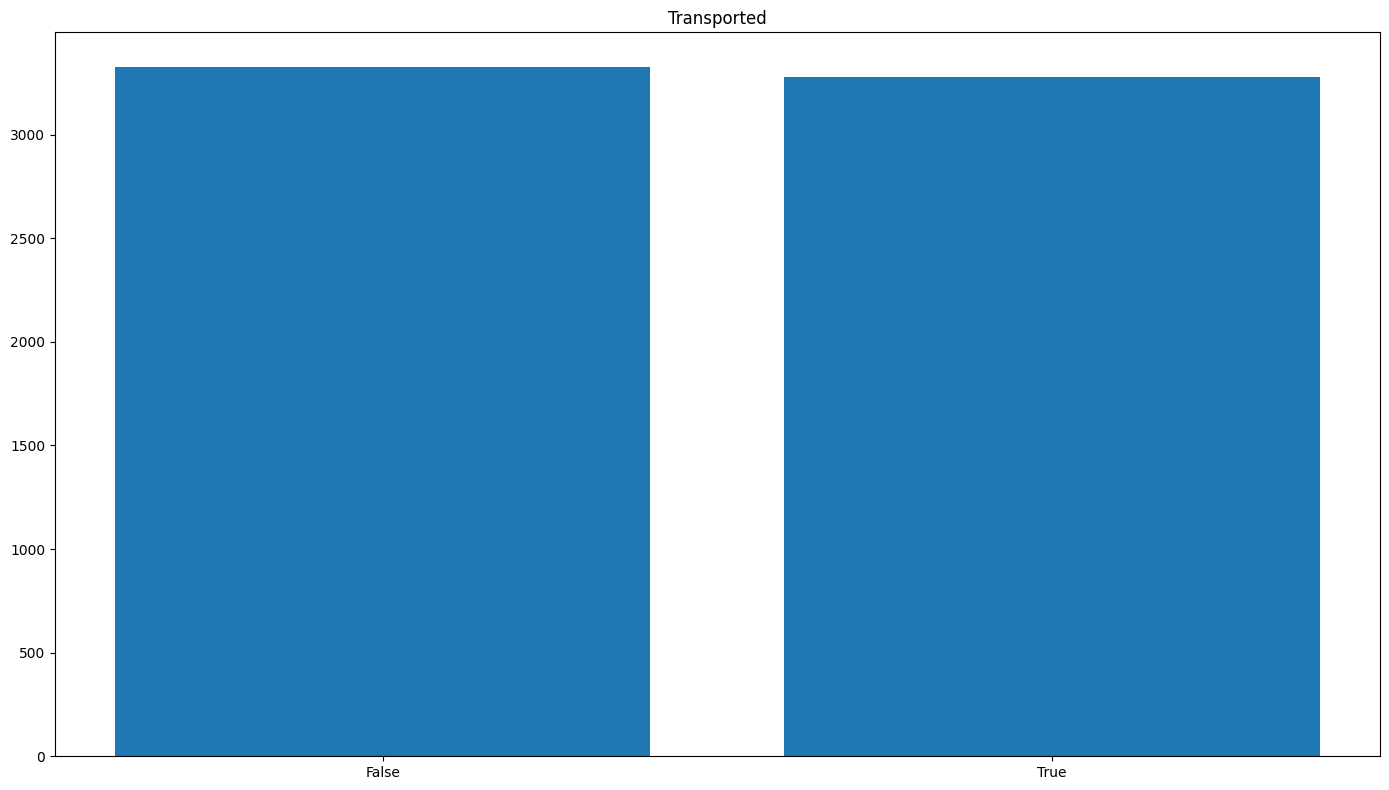

In [32]:
# 데이터 분석!
import matplotlib.pyplot as plt

transport_df = train_df[train_df['Transported'] == False]
# 생존자 비율~
fig, ax = plt.subplots(1, 1)
ax.set_title("Transported")
ax.bar(['False', 'True'], train_df['Transported'].value_counts())

plt.tight_layout()
plt.show()


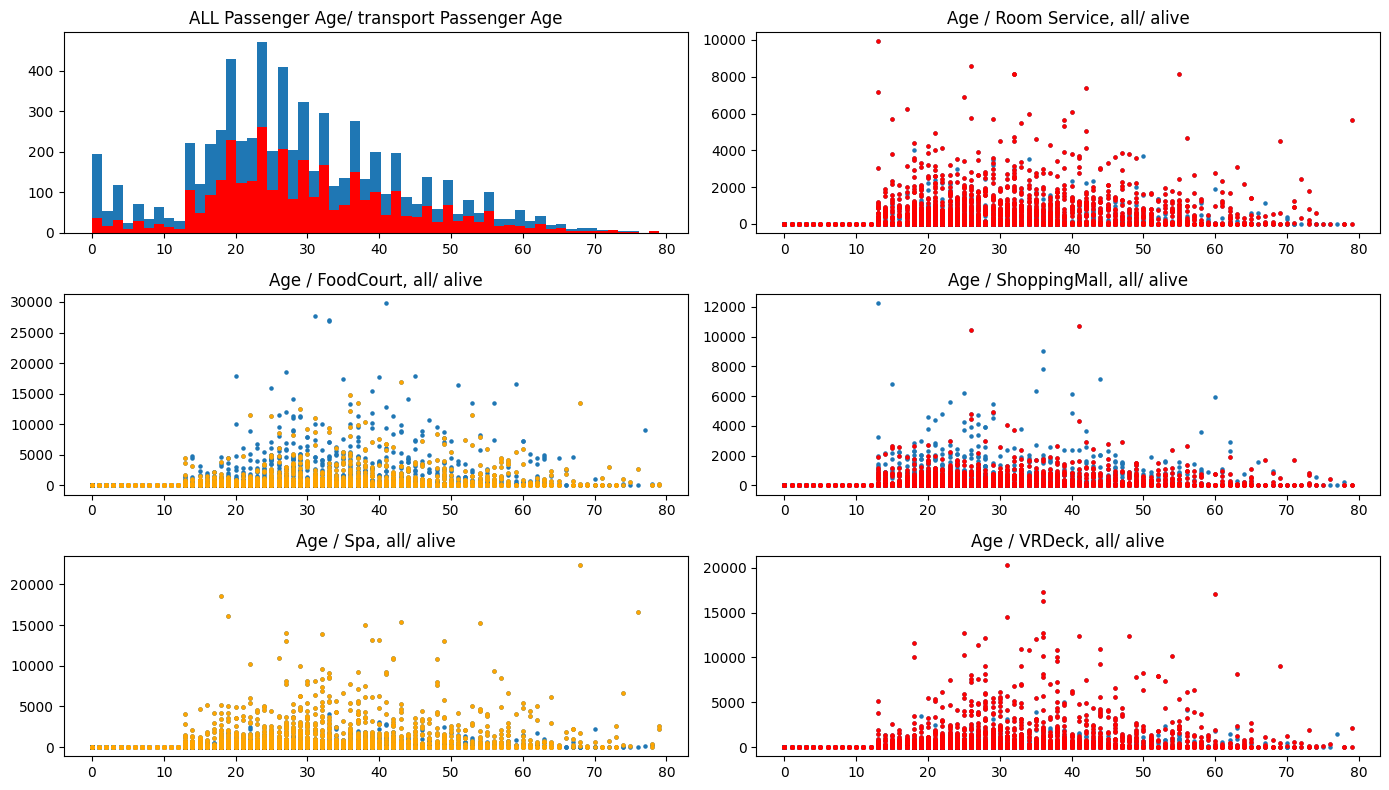

In [33]:
# 나이 상관관계 분석
fig, ax = plt.subplots(3, 2)

ax[0][0].hist(train_df['Age'], bins=55, label='ALL Passenger Age')
ax[0][0].set_title("ALL Passenger Age/ transport Passenger Age")
ax[0][0].hist(transport_df['Age'], bins=55, color='red', label='transport Passenger Age')

ax[0][1].scatter(train_df['Age'], train_df['RoomService'], s=5)
ax[0][1].scatter(transport_df['Age'], transport_df['RoomService'], color='red', s=5)
ax[0][1].set_title("Age / Room Service, all/ alive")

ax[1][0].scatter(train_df['Age'], train_df['FoodCourt'], s=5)
ax[1][0].scatter(transport_df['Age'], transport_df['FoodCourt'], color='orange', s=5)
ax[1][0].set_title("Age / FoodCourt, all/ alive")

ax[1][1].scatter(train_df['Age'], train_df['ShoppingMall'], s=5)
ax[1][1].scatter(transport_df['Age'], transport_df['ShoppingMall'], s=5, color='red')
ax[1][1].set_title("Age / ShoppingMall, all/ alive")

ax[2][0].scatter(train_df['Age'], train_df['Spa'], s=5)
ax[2][0].scatter(transport_df['Age'], transport_df['Spa'], s=5, color='orange')
ax[2][0].set_title("Age / Spa, all/ alive")

ax[2][1].scatter(train_df['Age'], train_df['VRDeck'], s=5)
ax[2][1].scatter(transport_df['Age'], transport_df['VRDeck'], s=5, color='red')
ax[2][1].set_title("Age / VRDeck, all/ alive")

plt.tight_layout()
plt.show()

162 102


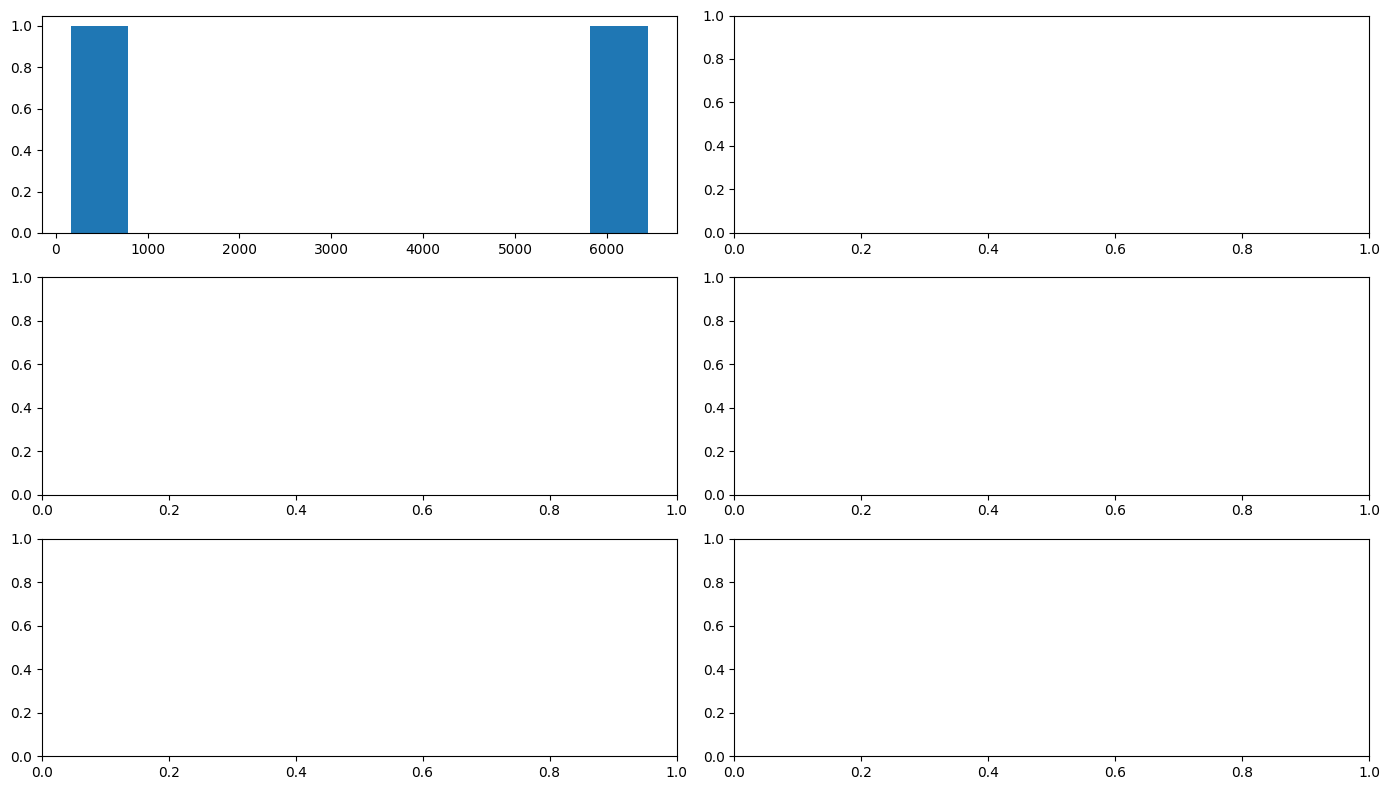

In [34]:
# VIP 상관관계 분석
print(len(train_df[train_df['VIP']==True]), len(transport_df[transport_df['VIP'] == True]))
fig, ax = plt.subplots(3, 2)

ax[0][0].hist(train_df['VIP'].value_counts())


plt.tight_layout()
plt.show()

In [35]:
df = train_df.select_dtypes(include=['number'])
df['Transported'] = train_df['Transported'].astype(int)
df['CryoSleep'] = train_df['CryoSleep'].astype(int)

print('------------------------------------------')
print(df.corr()['Transported'].sort_values(key=lambda x: x.abs()))

------------------------------------------
ShoppingMall    0.011602
VIP            -0.042260
Cabin_Num      -0.046766
FoodCourt       0.055025
SideDeck       -0.080749
Age            -0.082553
Side            0.106186
HomePlanet      0.111806
Deck           -0.112588
Destination    -0.123773
Total_Spend    -0.190992
Spend_Ratio    -0.196399
VRDeck         -0.207950
Spa            -0.219854
RoomService    -0.247291
CryoSleep       0.462803
Transported     1.000000
Name: Transported, dtype: float64


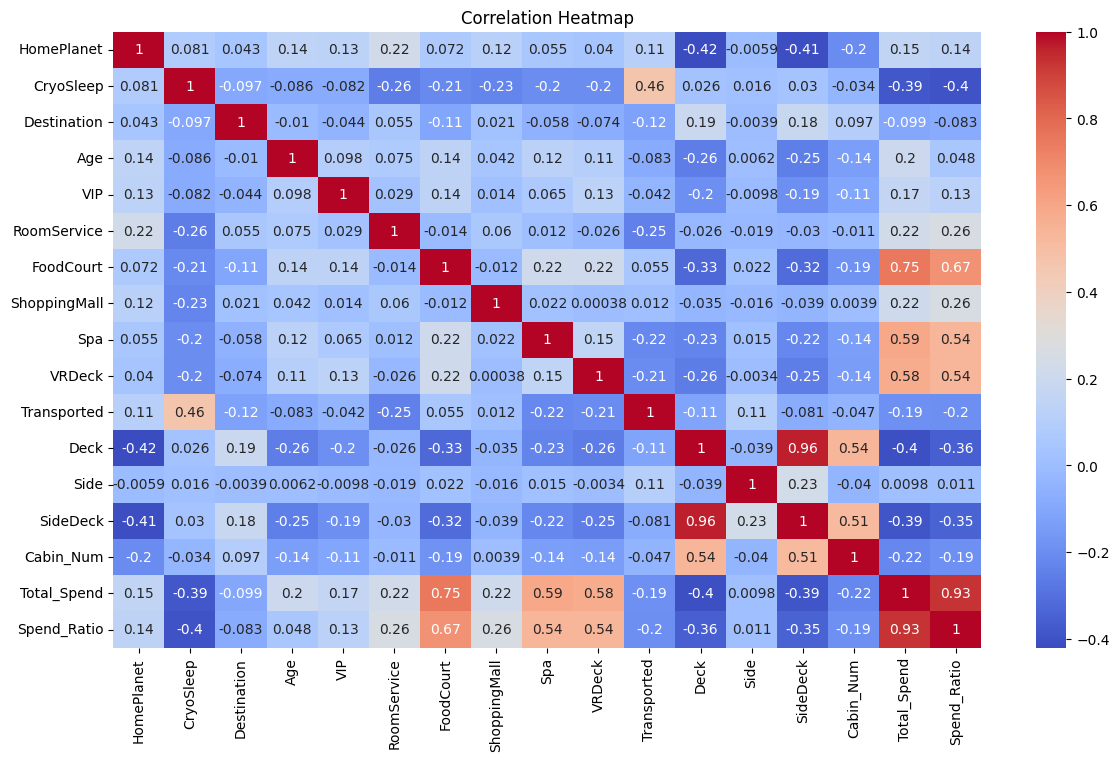

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 8)

corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

#### 상관 관계 도출.
- ShoppingMall    0.011602
- FoodCourt       0.055025
- Age            -0.082553
- Side            0.106186
- HomePlanet      0.111806
- CabDeckin      -0.112588
- Destination    -0.123773
- VRDeck         -0.207950
- Spa            -0.219854
- RoomService    -0.247291
- CryoSleep       0.462803
- Transported     1.000000

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# 결정트리 분류류
X = df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"결정트리 분류 정확도: {accuracy_score(y_pred, y_test)}")

결정트리 분류 정확도: 0.7596852300242131


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# 랜덤 포레스트 분류류
X = df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"랜덤포레스트 정확도: {accuracy_score(y_pred, y_test)}")

랜덤포레스트 정확도: 0.8056900726392252


In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb


# 랜덤 포레스트 분류
X = df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])


model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Xgb Boost 분류 정확도: {accuracy_score(y_pred, y_test)}")


Xgb Boost 분류 정확도: 0.8105326876513317


In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier


# "cat Boost
X = df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])


model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, verbose=100)


X_train, X_test, y_train, y_test = train_test_split(X, y)

model.fit(X_train, y_train)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.get_feature_importance()
})
print(feature_importance)
low_importance = feature_importance[feature_importance['Importance'] < 5]['Feature'].tolist()
print(low_importance)
y_pred = model.predict(X_test)

print(f"cat Boost 분류 정확도: {accuracy_score(y_pred, y_test)}")

0:	learn: 0.6698956	total: 3.13ms	remaining: 1.56s
100:	learn: 0.3717622	total: 157ms	remaining: 620ms
200:	learn: 0.3256901	total: 300ms	remaining: 446ms
300:	learn: 0.2930188	total: 441ms	remaining: 291ms
400:	learn: 0.2667645	total: 587ms	remaining: 145ms
499:	learn: 0.2449423	total: 725ms	remaining: 0us
         Feature  Importance
0     HomePlanet    9.626366
1      CryoSleep    4.865175
2    Destination    3.089790
3            Age    6.263026
4            VIP    0.180532
5    RoomService    4.948957
6      FoodCourt    7.828164
7   ShoppingMall    4.248720
8            Spa    8.583101
9         VRDeck    7.493201
10          Deck    9.707498
11          Side    3.755731
12      SideDeck    4.550094
13     Cabin_Num   10.643868
14   Total_Spend    7.233704
15   Spend_Ratio    6.982072
['CryoSleep', 'Destination', 'VIP', 'RoomService', 'ShoppingMall', 'Side', 'SideDeck']
cat Boost 분류 정확도: 0.8135593220338984


In [41]:
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

class ML_Model:
    def __init__(self, X, y):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, random_state=1)

        self.desiciontree = DecisionTreeClassifier()
        self.randomforest = RandomForestClassifier()
        self.xgboost = xgb.XGBClassifier(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
        self.cat_model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, verbose=100)

    def train(self):    
        self.desiciontree.fit(self.X_train, self.y_train)
        self.randomforest.fit(self.X_train, self.y_train)
        self.xgboost.fit(self.X_train, self.y_train)
        self.cat_model.fit(self.X_train, self.y_train)


        self.dtree_y_pred = self.desiciontree.predict(self.X_test)
        self.randomforest_y_pred = self.randomforest.predict(self.X_test)
        self.xgboost_y_pred = self.xgboost.predict(self.X_test)
        self.catboost_y_pred = self.cat_model.predict(self.X_test)
    
    def evaluate(self):
        
        pred_list = [self.dtree_y_pred, self.randomforest_y_pred,
                     self.xgboost_y_pred, self.catboost_y_pred]
        best_score = 0
        best_idnex = 0
        for index, pred in enumerate(pred_list):

            score = accuracy_score(self.y_test, pred)
            if score > best_score:
                best_idnex = index
                best_score = score
                

            print(f"정확도: {accuracy_score(self.y_test, pred)}")
        print(f'최고 정확도: {best_score}, 최고 모델: {best_idnex}')

In [42]:

X = df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])
X_reduced = X.drop(columns=low_importance)

ml_model = ML_Model(X_reduced, y)
ml_model.train()
ml_model.evaluate()

0:	learn: 0.6725582	total: 3.13ms	remaining: 1.56s
100:	learn: 0.4119000	total: 141ms	remaining: 558ms
200:	learn: 0.3783932	total: 272ms	remaining: 404ms
300:	learn: 0.3464758	total: 401ms	remaining: 265ms
400:	learn: 0.3200752	total: 529ms	remaining: 131ms
499:	learn: 0.2989841	total: 677ms	remaining: 0us
정확도: 0.7088377723970944
정확도: 0.7542372881355932
정확도: 0.7705811138014528
정확도: 0.7705811138014528
최고 정확도: 0.7705811138014528, 최고 모델: 2


In [43]:
X = df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.get_feature_importance()
})
print(feature_importance)
low_importance = feature_importance[feature_importance['Importance'] < 5]['Feature'].tolist()
print(low_importance)
X_reduced = X.drop(columns=low_importance)

# test_y = pd.read_csv('data/test.csv')
test_y = test_y.select_dtypes(include=['number'])

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y)

model = ml_model.cat_model
model.fit(X_train, y_train)

y_pred = model.predict(test_y)
print(y_pred)
# print(f"랜덤포레스트 정확도: {accuracy_score(y_pred, y_test)}")

         Feature  Importance
0     HomePlanet    9.626366
1      CryoSleep    4.865175
2    Destination    3.089790
3            Age    6.263026
4            VIP    0.180532
5    RoomService    4.948957
6      FoodCourt    7.828164
7   ShoppingMall    4.248720
8            Spa    8.583101
9         VRDeck    7.493201
10          Deck    9.707498
11          Side    3.755731
12      SideDeck    4.550094
13     Cabin_Num   10.643868
14   Total_Spend    7.233704
15   Spend_Ratio    6.982072
['CryoSleep', 'Destination', 'VIP', 'RoomService', 'ShoppingMall', 'Side', 'SideDeck']
0:	learn: 0.6724967	total: 2.71ms	remaining: 1.35s
100:	learn: 0.4184557	total: 180ms	remaining: 712ms
200:	learn: 0.3830400	total: 351ms	remaining: 523ms
300:	learn: 0.3520360	total: 484ms	remaining: 320ms
400:	learn: 0.3264947	total: 611ms	remaining: 151ms
499:	learn: 0.3064859	total: 745ms	remaining: 0us
[1 0 1 ... 1 1 1]


In [44]:
template_df = pd.read_csv('data/test.csv')
dd = template_df['PassengerId']

# int(dd)
ddf = pd.Series(y_pred, name='Transported')
ddf = ddf.map({1: 'True', 0: 'False'})
ds = pd.concat([dd ,ddf], axis=1)
print(ds)
ds.to_csv("result.csv", index=False)

     PassengerId Transported
0        0013_01        True
1        0018_01       False
2        0019_01        True
3        0021_01        True
4        0023_01       False
...          ...         ...
4272     9266_02        True
4273     9269_01       False
4274     9271_01        True
4275     9273_01        True
4276     9277_01        True

[4277 rows x 2 columns]


In [58]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


X = df.select_dtypes(include=['number'])
y = train_df.Transported
X = X.drop(columns=['Transported'])

cat_model = CatBoostClassifier(iterations=1000, learning_rate=0.01, depth=6, verbose=100)
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=4)
# model = VotingClassifier(estimators=[('cat', cat_model), ('xgb', xgb_model)], voting='soft')

estimators = [('cat', cat_model), ('xgb', xgb_model)]
model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

test_y = test_y[X.columns].fillna(0)
test_y = test_y.select_dtypes(include=['number'])
X_train, X_test, y_train, y_test = train_test_split(X, y)

# model = ml_model.cat_model
model.fit(X_train, y_train)

y_pred = model.predict(test_y)
print(y_pred)

0:	learn: 0.6884200	total: 4.39ms	remaining: 4.39s
100:	learn: 0.4814995	total: 166ms	remaining: 1.47s
200:	learn: 0.4283436	total: 344ms	remaining: 1.36s
300:	learn: 0.4023228	total: 531ms	remaining: 1.23s
400:	learn: 0.3857583	total: 710ms	remaining: 1.06s
500:	learn: 0.3717699	total: 891ms	remaining: 888ms
600:	learn: 0.3612965	total: 1.05s	remaining: 697ms
700:	learn: 0.3522192	total: 1.21s	remaining: 517ms
800:	learn: 0.3441699	total: 1.36s	remaining: 338ms
900:	learn: 0.3355165	total: 1.51s	remaining: 166ms
999:	learn: 0.3269387	total: 1.65s	remaining: 0us
0:	learn: 0.6882051	total: 4.61ms	remaining: 4.61s
100:	learn: 0.4819019	total: 138ms	remaining: 1.23s
200:	learn: 0.4303848	total: 259ms	remaining: 1.03s
300:	learn: 0.4029362	total: 385ms	remaining: 894ms
400:	learn: 0.3846960	total: 520ms	remaining: 776ms
500:	learn: 0.3704874	total: 640ms	remaining: 637ms
600:	learn: 0.3591148	total: 773ms	remaining: 513ms
700:	learn: 0.3492733	total: 899ms	remaining: 383ms
800:	learn: 0.33

In [56]:
template_df = pd.read_csv('data/test.csv')
dd = template_df['PassengerId']

# int(dd)
ddf = pd.Series(y_pred, name='Transported')
ddf = ddf.map({1: 'True', 0: 'False'})
ds = pd.concat([dd ,ddf], axis=1)
print(ds)
ds.to_csv("result.csv", index=False)

     PassengerId Transported
0        0013_01        True
1        0018_01       False
2        0019_01        True
3        0021_01        True
4        0023_01        True
...          ...         ...
4272     9266_02        True
4273     9269_01        True
4274     9271_01        True
4275     9273_01        True
4276     9277_01       False

[4277 rows x 2 columns]
